# Importing the dependencies

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler

# Importing the models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score,KFold

In [2]:
# Loading training data
df = pd.read_csv('../Dataset/Load_Eligibility_ds/loan-train.csv')
df.head(4)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y


In [3]:
# Replacing Yes with 1 and No with 0
df['Loan_Status'] = df['Loan_Status'].replace('Y',1)
df['Loan_Status'] = df['Loan_Status'].replace('N',0)

# Defining the utility function

In [4]:
# Finding the upper and lower limit
def find_limits(column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1
    Upper_lmt = q3 + 1.5*IQR
    Lower_lmt = q1 - 1.5*IQR
    return [Upper_lmt,Lower_lmt]

In [5]:
# Removing unnecessary attribue
df.drop(['Loan_ID'],axis=1,inplace=True)

# Exploratory data analysis

In [6]:
# Shape of the dataframe
df.shape

(614, 12)

In [7]:
# Getting feature information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 57.7+ KB


In [8]:
# Removing duplicate values if they exist
duplicate_values = df.duplicated().sum()
if duplicate_values > 0:
    print("Total "+ str() + " duplicate values removed")
    df.drop_duplicated(inplace=True)
else:
    print("There are no duplicate values")

There are no duplicate values


Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64


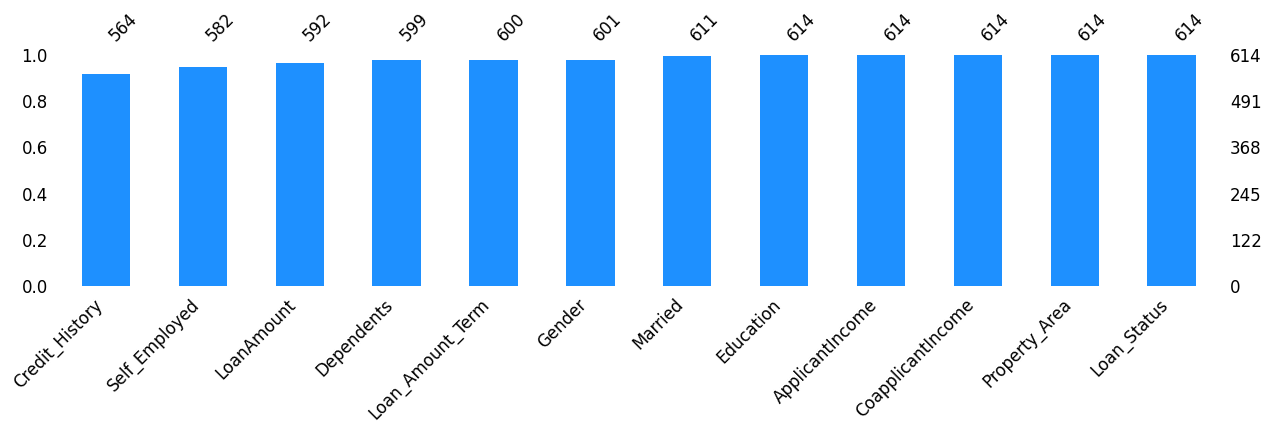

In [9]:
# Checking any missing values
print(df.isnull().mean()*100)

# Visualize missing values using a bar chart
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

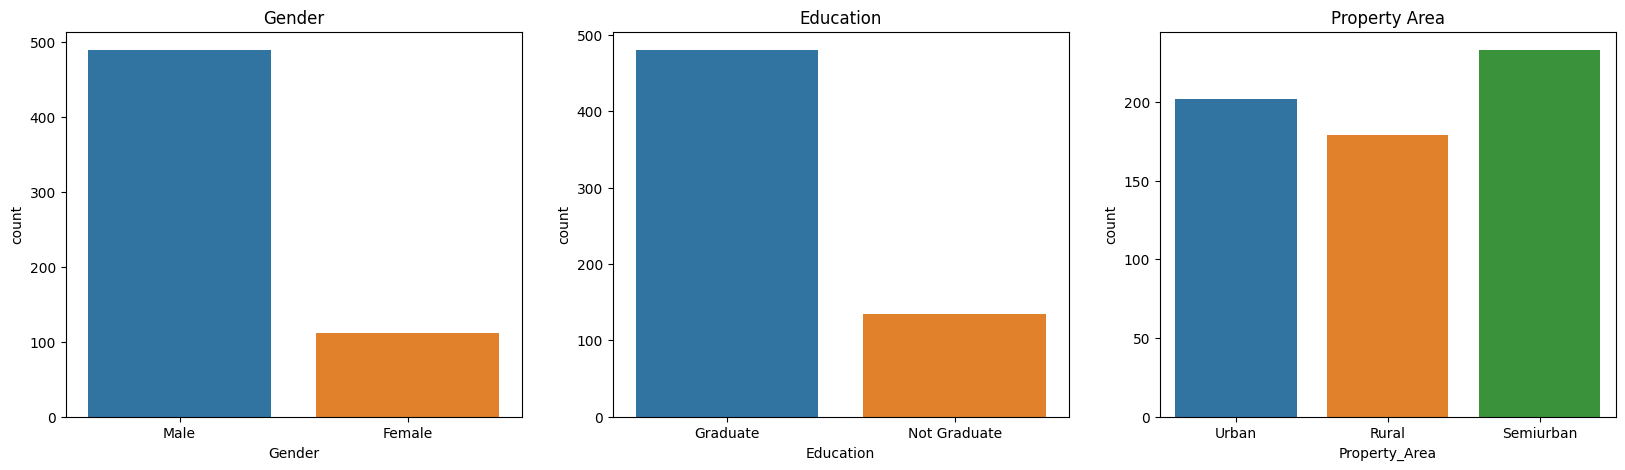

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(x='Gender', data=df, ax=ax[0])
ax[0].set_title('Gender')

sns.countplot(x='Education', data=df, ax=ax[1])
ax[1].set_title('Education')

sns.countplot(x='Property_Area', data=df, ax=ax[2])
ax[2].set_title('Property Area')

plt.show()

# Data Processing and Feature engineeering

In [11]:
# Creating a temporary copy of the dataframe
temp_df = df.copy()
temp_df.head(4)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1


In [12]:
# Storing all the features with less than 5% Missing values
Less_5PER_NaN = []
for cols in temp_df.columns:
    if (temp_df[cols].isnull().mean()*100) > 0 & (temp_df[cols].isnull().mean()*100 < 5):
        Less_5PER_NaN.append(cols)

Less_5PER_NaN

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [13]:
# Univariate mean and mode imputation
for cols in Less_5PER_NaN:
    if (temp_df[cols].dtype == int) or (temp_df[cols].dtype == float):
        temp_df[cols] = temp_df[cols].fillna(temp_df[cols].median())
    else:
        temp_df[cols] = temp_df[cols].fillna(temp_df[cols].mode()[0])

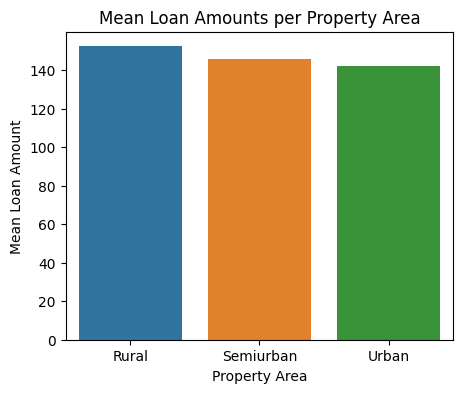

In [14]:
# Calculate mean loan amounts per property area
loan_per_area = df.groupby('Property_Area')['LoanAmount'].mean().reset_index()

# Plotting using sns.barplot
plt.figure(figsize=(5, 4))
sns.barplot(x='Property_Area', y='LoanAmount', data=loan_per_area)
plt.title('Mean Loan Amounts per Property Area')
plt.xlabel('Property Area')
plt.ylabel('Mean Loan Amount')
plt.show()

In [15]:
map_Dependents = {'0': 0, '1': 1, '2': 2, '3+': 3}
map_Education = {'Graduate':1, 'Not Graduate':2}
map_Self_Employed = {'No':0, 'Yes':1}

# Encoding the features
df['Dependents'] = df['Dependents'].replace(map_Dependents)
df['Education'] = df['Education'].replace(map_Education)
df['Self_Employed'] = df['Self_Employed'].replace(map_Self_Employed)

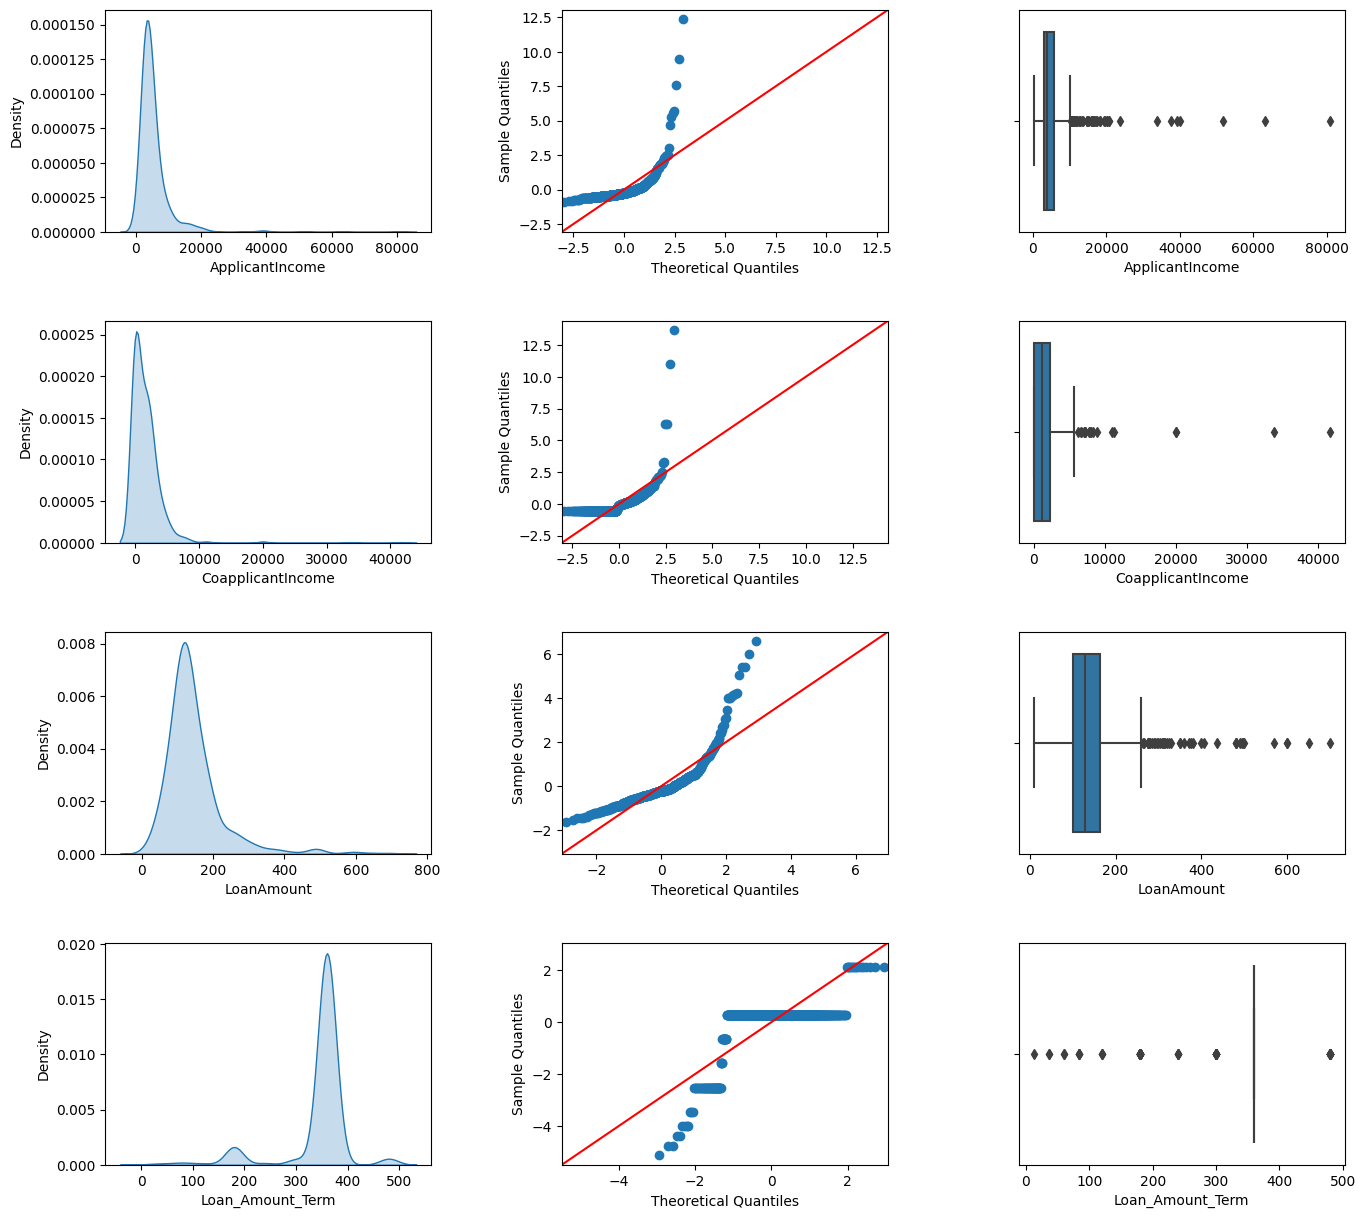

In [16]:
fig, ax = plt.subplots(4, 3, figsize=(16, 15))

# Plot KDE plots in the first column
sns.kdeplot(data=temp_df, x='ApplicantIncome', ax=ax[0, 0], shade=True)
sns.kdeplot(data=temp_df, x='CoapplicantIncome', ax=ax[1, 0], shade=True)
sns.kdeplot(data=temp_df, x='LoanAmount', ax=ax[2, 0], shade=True)
sns.kdeplot(data=temp_df, x='Loan_Amount_Term', ax=ax[3, 0], shade=True)

# Plot Q-Q plots in the second column
sm.qqplot(temp_df['ApplicantIncome'], line='45', ax=ax[0, 1], fit=True)
sm.qqplot(temp_df['CoapplicantIncome'], line='45', ax=ax[1, 1], fit=True)
sm.qqplot(temp_df['LoanAmount'], line='45', ax=ax[2, 1], fit=True)
sm.qqplot(temp_df['Loan_Amount_Term'], line='45', ax=ax[3, 1], fit=True)

# Plot box plots in the fourth column (corrected indices)
sns.boxplot(x='ApplicantIncome', data=temp_df, ax=ax[0, 2])
sns.boxplot(x='CoapplicantIncome', data=temp_df, ax=ax[1, 2])
sns.boxplot(x='LoanAmount', data=temp_df, ax=ax[2, 2])
sns.boxplot(x='Loan_Amount_Term', data=temp_df, ax=ax[3, 2])

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [17]:
# Ordinal encoding the features
Education_encode = OrdinalEncoder(categories=[['Graduate', 'Not Graduate']], handle_unknown="use_encoded_value", unknown_value=np.nan)
Self_Employed_encode = OrdinalEncoder(categories=[['No', 'Yes']], handle_unknown="use_encoded_value", unknown_value=np.nan)
Dependents_encode = OrdinalEncoder(categories=[['0', '1', '2', '3+']], handle_unknown="use_encoded_value", unknown_value=np.nan)

temp_df['Education'] = Education_encode.fit_transform(temp_df['Education'].values.reshape(-1, 1)).reshape(-1)
temp_df['Self_Employed'] = Self_Employed_encode.fit_transform(temp_df['Self_Employed'].values.reshape(-1, 1)).reshape(-1)
temp_df['Dependents'] = Dependents_encode.fit_transform(temp_df['Dependents'].values.reshape(-1, 1)).reshape(-1)

In [18]:
# One-hot encoding
gender_encoded = pd.get_dummies(temp_df['Gender'], prefix='Gender').astype(int)
married_encoded = pd.get_dummies(temp_df['Married'], prefix='Married').astype(int)
property_area_encoded = pd.get_dummies(temp_df['Property_Area'], prefix='Property_Area').astype(int)

In [19]:
# Concatenate the one-hot encoded DataFrames
temp_df = pd.concat([temp_df, gender_encoded, married_encoded, property_area_encoded], axis=1)

# Drop the original categorical columns
temp_df = temp_df.drop(['Gender', 'Married', 'Property_Area'], axis=1)

### Correlation analysis

If the features in a regression model are not highly correlated, it generally eliminates the concerns related to multicollinearity. In fact, low correlation between features is often preferred in regression modeling. Here are some reasons why low correlation between features is beneficial:

1. Improved Interpretability: When features are not highly correlated, it is easier to interpret the individual impact of each variable on the target variable. The coefficients in the regression equation represent the change in the target variable for a one-unit change in the corresponding predictor, holding other predictors constant.

2. Stable Coefficients: With low correlation, the coefficients of the individual predictors tend to be more stable and less sensitive to changes in the dataset. This stability enhances the reliability of the model.

3. Reduced Redundancy: Low correlation indicates that the information provided by each feature is relatively unique. Redundant information can lead to overfitting and does not contribute significantly to the predictive power of the model.

4. Feature Importance: In models like linear regression, low correlation helps in identifying the most important features, as the coefficients are less likely to be influenced by collinearity.

5. Efficient Model Training: Low correlation between features can also improve the efficiency of model training, as the model doesn't have to navigate through highly correlated feature spaces.

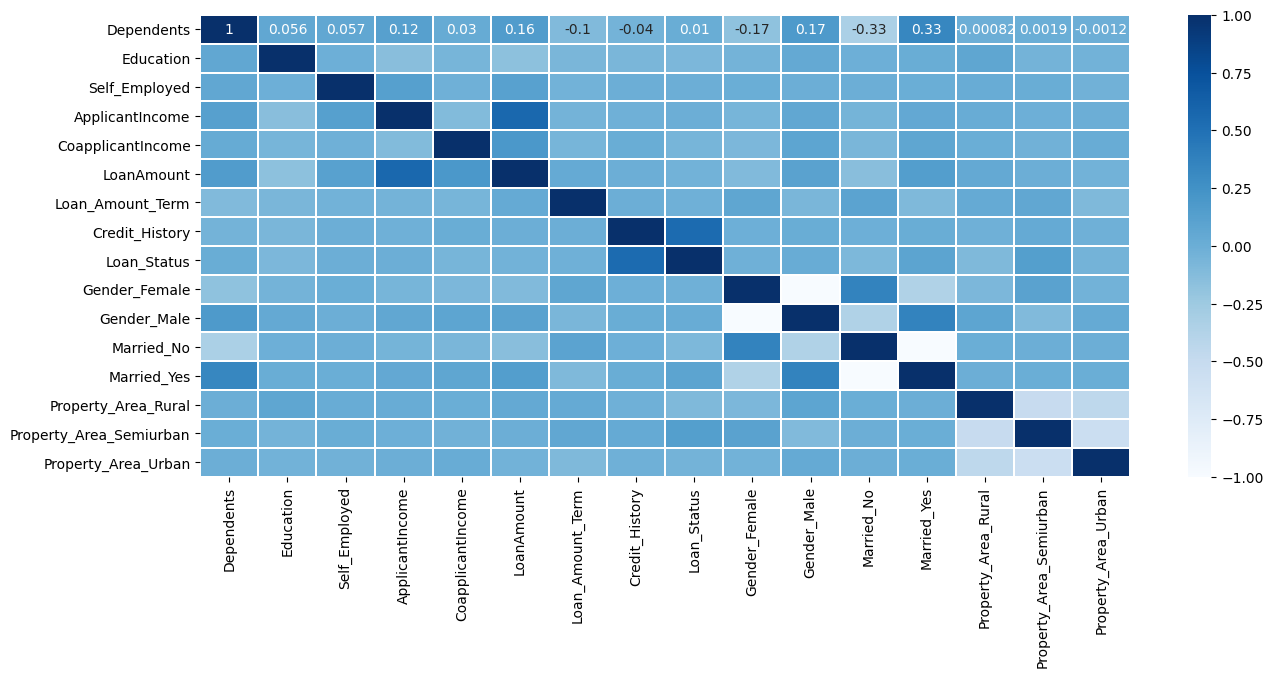

In [20]:
plt.figure(figsize=(15, 6))
sns.heatmap(temp_df.corr(), annot=True,cmap="Blues",linewidths = 0.1)
plt.show()

In [21]:
temp_df.drop(['Gender_Female','Married_No'],axis=1,inplace=True)

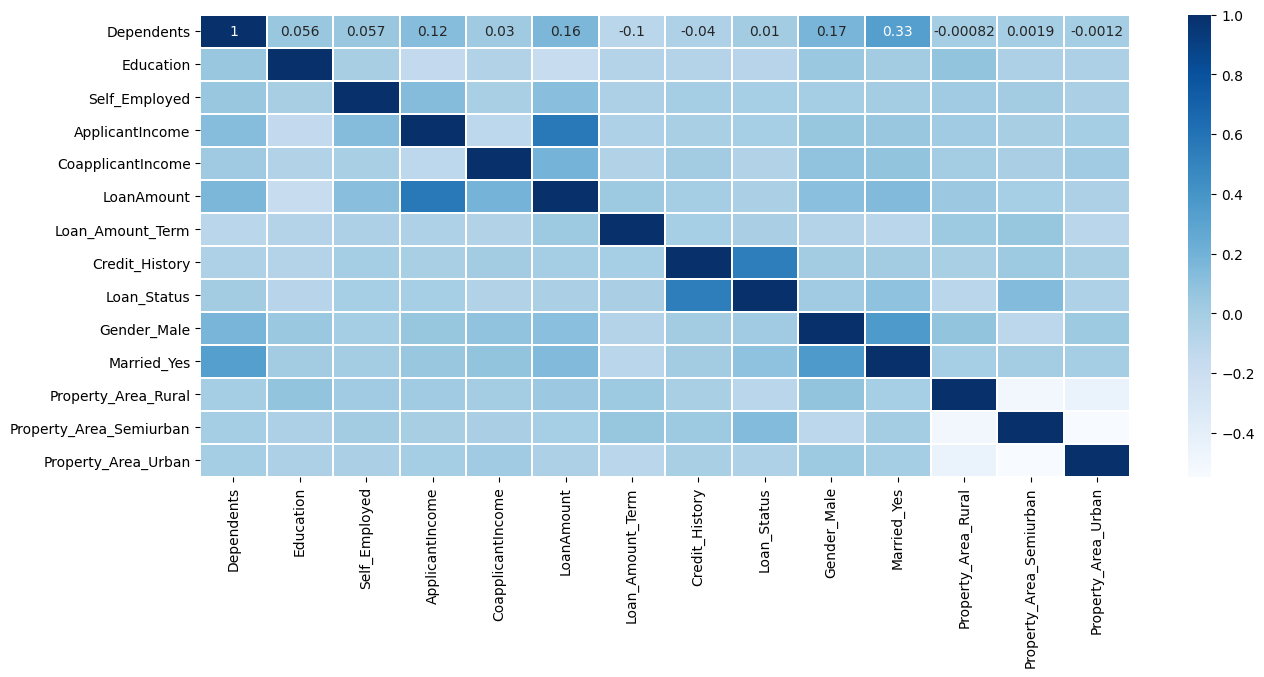

In [22]:
plt.figure(figsize=(15, 6))
sns.heatmap(temp_df.corr(), annot=True,cmap="Blues",linewidths = 0.1)
plt.show()

# Dealing with missing values

In [23]:
# Univariate mean and mode imputation
for cols in Less_5PER_NaN:
    if (df[cols].dtype == int) or (df[cols].dtype == float):
        df[cols] = df[cols].fillna(df[cols].median())
    else:
        df[cols] = df[cols].fillna(df[cols].mode()[0])

# Feature Selection

After doing one hot encoding of the Gender feature we will have features = (Number of unique values in gender feature), similarly for the other features as well there will be some dummy features that will be excessive so we need to make sure that the less related features are removed 

# Train test split

In [ ]:
new_order = ['Gender', 'Married', 'Property_Area','Dependents', 'Education', 'Self_Employed','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status']
df = df.reindex(columns=new_order)

In [26]:
X = df.drop(['Loan_Status'],axis=1)
y = df['Loan_Status']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 1)
print("Training data shape : ",X_train.shape)
print("Testing data shape : ",X_test.shape)

Training data shape :  (491, 11)
Testing data shape :  (123, 11)


# Data processing pipeline

In [27]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers=[
    ('Encode_Gender', OneHotEncoder(handle_unknown='ignore', drop='first'), [0]),
    ('Encode_Married', OneHotEncoder(handle_unknown='ignore', drop='first'), [1]),
    ('Encode_Property_Area', ce.TargetEncoder(cols=['Property_Area']), [2]),
],remainder='passthrough')


# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers=[
    ('MinMaxScaling', MinMaxScaler(copy=False), [2,3,6,7,8,9])
], remainder='passthrough')


# Stacking column transformers to create a Processing pipeline
Processing_pipeline = Pipeline(steps=[
    ('Encoding', encoding_transformer),
    ('Scaling', scaling_transformer),
], memory='Temp')

In [28]:
# Transforming the data
# X_train = Processing_pipeline.fit_transform(X_train,y_train)
# X_test = Processing_pipeline.transform(X_test)

# Model performance Comparision

In [29]:
def scorer(model_name, model):
    """
    This function takes a model name as input and injects that model into the training pipeline to process 
    and train the model using the training data. After that, this function uses K-fold cross-validation technique
    to calculate the average accuracy score.
    
    Parameters:
    - model_name (str): Name of the model.
    - model: The machine learning model to be trained and evaluated.

    Returns:
    List: A list containing the model name and its average accuracy score.
    """
    
    output = []
    output.append(model_name)
    
    # Stacking column transformers to create a Training pipeline
    Training_pipeline = Pipeline(steps=[
        ('Encoding', encoding_transformer),
        ('Scaling', scaling_transformer),
        ('classifier', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(Training_pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    output.append(scores.mean())

    # Training the model and getting predictions
    Training_pipeline.fit(X_train, y_train)
    y_pred = Training_pipeline.predict(X_test)
    
    # Using accuracy_score for classification
    accuracy = f1_score(y_test, y_pred)
    output.append(accuracy)
    
    return output

In [30]:
# Dictionary of classification models
classification_model_dict = {
    'logistic_regression': LogisticRegression(),
    'naive_bayes': GaussianNB(),
    'support_vector_machine': SVC(),
    'k_neighbors': KNeighborsClassifier(),
    'decision_tree': DecisionTreeClassifier(),
    'random_forest': RandomForestClassifier(),
    'extra_trees': ExtraTreesClassifier(),
    'gradient_boosting': GradientBoostingClassifier(),
    'adaboost': AdaBoostClassifier(),
    'mlp': MLPClassifier(max_iter=5000),
    'xgboost': XGBClassifier()
}

In [31]:
model_output = []
for model_name,model in classification_model_dict.items():
    model_output.append(scorer(model_name, model))

In [32]:
model_df = pd.DataFrame(model_output, columns=['name','accuracy','f1_score'])
model_df.sort_values(['f1_score'])

,name,accuracy,f1_score
4,decision_tree,0.684204,0.760736
6,extra_trees,0.777918,0.813559
3,k_neighbors,0.771796,0.835165
5,random_forest,0.794245,0.836957
7,gradient_boosting,0.790163,0.860215
10,xgboost,0.769755,0.860335
9,mlp,0.790082,0.866310
1,naive_bayes,0.788082,0.870968
0,logistic_regression,0.810490,0.873684
2,support_vector_machine,0.810490,0.873684


# Model training

# Model evaluation

In [22]:
coapp_lmts = find_limits('CoapplicantIncome')
print(coapp_lmts[0])
print(coapp_lmts[1])

5743.125
-3445.875


In [32]:
ApplicantIncome_lmts = find_limits('ApplicantIncome')
print(ApplicantIncome_lmts[0])
print(ApplicantIncome_lmts[1])

10171.25
-1498.75


In [35]:
df[(df['CoapplicantIncome'] > coapp_lmts[0]) | (df['ApplicantIncome'] > ApplicantIncome_lmts[0])].shape[0]

66